# Canada's Monetary Policy Report: if text could speak, what would it say?

## This notebook creates the first 5 figures in the Staff Analytical Note (History of the MPR, Word Cloud, Readability, Length, and Lexical innovations).

### This workbook should "just work". If it does not, or if you find an error, please email the authors.

##### André Binette <abinette@bankofcanada.ca>

##### Dmitri Tchebotarev

------------------------------------------------------------------------------------------------------------------------------

-----------------------------------------------------

## Set up the environment

### Import required modules

In [1]:
from IPython.display import FileLink, FileLinks

import numpy as np
import seaborn as sns
from scipy import stats
import requests
from io import BytesIO
from zipfile import ZipFile
from bs4 import BeautifulSoup
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import datetime as dt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import textacy
import os
import sys
from readcalc import readcalc
import re
import spacy
from PIL import Image

from cytoolz import itertoolz
from textacy import extract, compat
from sklearn.metrics import pairwise_distances
from collections import defaultdict
import collections
from itertools import starmap
import socket
import pandas as pd 

import libwmdrelax
import wordcloud as wc

import nltk
nltk.download('punkt')
from nltk import sent_tokenize

[nltk_data] Downloading package punkt to /home/res/bina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
%matplotlib inline

## Define helper functions

In [3]:
def preformat(text):
    text = text.replace('\n',' ')
    text = re.sub("\((?:See|Chart|Table|Box|Technical).*?\)","",text)
    return text

In [4]:
# function takes an iterable of docs and returns top bigrams 
def maket(it):
    total = dict()
    for c in it:
        td = dict()
        dv = textacy.extract.ngrams(c,2)
        for d in dv:
            if any([j.is_stop for j in d]):
                continue
            t = d.text
            if any([k in t for k in ['Report','Update','The',"'"]]):
                    continue
            t = t.replace('’',"'")
            td[t] = td.get(t,0) + 1
        for d in td.items():
            total[d[0]] = total.get(d[0],0) + d[1]
    return total

-------------------------

## Load spacy language model and MPR corpus

In [5]:
nlp = spacy.load('en_core_web_lg')
for word in nlp.Defaults.stop_words:
    lex = nlp.vocab[word]
    lex.is_stop = True
nlp_vec = spacy.load('en_core_web_lg',disable=['parser','ner','tagger'])

In [6]:
file_list = [file for file in os.listdir('./mpr_text/') if file.endswith('.txt')]
metadata = []
data = []
file_list = list(sorted(file_list))
for file in file_list:
    y,m,d=map(int,file.split('.')[0].split('-')[1:])
    # these two checks are to omit MPR updates
    if y<2009 and m in (1,2,7,8):
        continue
    if y==2009 and m==1:
        continue
    with open('./mpr_text/' + file,encoding='utf-8') as ff:
        data.append(preformat(ff.read()))
        metadata.append(datetime.strptime(file,'mpr-%Y-%m-%d.txt').date())

In [7]:
corpus = textacy.Corpus(nlp, texts=data, metadatas = metadata)

----------------------------

## Create a list of governors per MPR

In [8]:
govs = ['Thiessen']*12 + ['Dodge']*14 + ['Carney']*19
while len(govs) < len(metadata):
    govs.append('Poloz')

----------------

## Figures

### Figure 1 - History of the MPR

/home/res/bina/.conda/envs/mpr/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


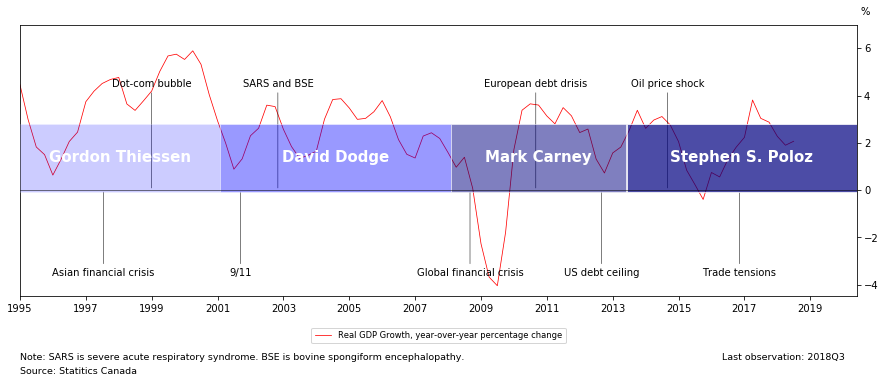

In [9]:
#Import the GDP data from Statcan
table_num = "36100104"
link = 'https://www150.statcan.gc.ca/n1/tbl/csv/{table_num}-eng.zip'.format(table_num=table_num)
r = requests.get(link)
zip_file = ZipFile(BytesIO(r.content))
GDP_fisher = pd.read_csv(zip_file.open('{table_num}.csv'.format(table_num=table_num)), index_col=10,na_values=['..','...','x','F'])  

# Show only the necessary values using V-number
GDP_fisher = GDP_fisher.loc['v62305752']
Index2 = GDP_fisher.REF_DATE.values
GDP_fisher.index = Index2
GDP_fisher = GDP_fisher.drop(['REF_DATE', 'GEO', 'DGUID', 'Seasonal adjustment', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'], axis =1)
GDP_fisher = GDP_fisher.pivot_table(index = GDP_fisher.index, columns = 'Prices', values = 'VALUE')
GDP_fisher.columns = ['real GDP (fisher)']
GDP_fisher = GDP_fisher.loc['1994-01':,]

# Create the year over year real GDP growth for each quarter 
GDP_fisher = (GDP_fisher/GDP_fisher.shift(4) - 1)*100
GDP_fisher = GDP_fisher.loc['1995-01':,]
GDP_fisher.columns = ['Real GDP Growth']

# Change to necessary date format for plot 
GDP_fisher.index = pd.to_datetime(GDP_fisher.index)
dates = mdates.date2num(GDP_fisher.index.to_pydatetime())
values = GDP_fisher.loc[:,'Real GDP Growth'].values

# Plot
fig = plt.figure(figsize=(15,5))
plt.axhline(0,color='k', zorder=20,linewidth=.5)
ax = fig.add_subplot(111)
ymax = 7
ymin = -4.5
difference = ymax - ymin

thiessenstarttime = (dt.date(1995,1,1))
thiessenendtime = (dt.date(2001,1,31))
thiessenstart = mdates.date2num(thiessenstarttime)
thiessenend = mdates.date2num(thiessenendtime)
thiessenwidth = thiessenend - thiessenstart 

dodgestarttime = (dt.date(2001,2,1))
dodgeendtime = (dt.date(2008,1,31))
dodgestart = mdates.date2num(dodgestarttime)
dodgeend = mdates.date2num(dodgeendtime)
dodgewidth = dodgeend - dodgestart 

carneystarttime = (dt.date(2008,2,1))
carneyendtime = (dt.date(2013,6,1))
carneystart = mdates.date2num(carneystarttime)
carneyend = mdates.date2num(carneyendtime)
carneywidth = carneyend - carneystart 

polozstarttime = (dt.date(2013,6,3))
polozendtime = (dt.date(2020,6,2))
polozstart = mdates.date2num(polozstarttime)
polozend = mdates.date2num(polozendtime)
polozwidth = polozend - polozstart 

rectangles = {'Gordon Thiessen' :patches.Rectangle((thiessenstart,.385*difference+ymin),
                                                   thiessenwidth,(.25*difference), linewidth = 1,
                                                   edgecolor ='w', facecolor='blue', zorder=5, alpha=.2),
              'David Dodge': patches.Rectangle((dodgestart,.385*difference+ymin),dodgewidth,
                                               (.25*difference), linewidth = 1, edgecolor ='w',
                                               facecolor='blue',zorder=5, alpha=.4),
              'Mark Carney': patches.Rectangle((carneystart,.385*difference+ymin),carneywidth
                                               ,(.25*difference), linewidth = 1, edgecolor ='w',
                                               facecolor='navy',zorder=5, alpha=.5),
              'Stephen S. Poloz': patches.Rectangle((polozstart,.385*difference+ymin),polozwidth,
                                                   (.25*difference), linewidth = 1,edgecolor ='w',
                                                   facecolor='navy',zorder=5, alpha=.7)}

for r in rectangles:
    ax.add_artist(rectangles[r])
    rx, ry = rectangles[r].get_xy()
    cx = rx + rectangles[r].get_width()/2.0
    cy = ry + rectangles[r].get_height()/2.0
    ax.annotate(r, (cx, cy), color='white', weight='bold', 
                fontsize=15, ha='center', va='center', zorder=20)

locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.xlim((dt.date(1995,1,1),dt.date(2020,6,2)))
plt.ylim((ymin,ymax))
years = pd.to_datetime(range(1995,2020,2), format='%Y')
yearnumbers = mdates.date2num(years.to_pydatetime())
plt.xticks(yearnumbers)
ax.yaxis.tick_right()
plt.yticks([-4,-2,0,2,4,6])
#ax.yaxis.set_label_position("right")
ax.yaxis.set_label_coords(1.01, 1.028, transform=None)
plt.ylabel('%', rotation=0)


starttime = (dt.date(1995,1,1))
endtime = (dt.date(2022,1,31))
start = mdates.date2num(starttime)
end = mdates.date2num(endtime)
width = end - start 

headstarttime = (dt.date(2015,2,1))
headendtime = (dt.date(2022,1,31))
headstart = mdates.date2num(headstarttime)
headend = mdates.date2num(headendtime)
headwidth = headend - headstart 

plt.plot(dates,values, color ='red', label = 'Real GDP Growth, year-over-year percentage change', linewidth=.75)
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.1),fontsize = 'small')

plt.text(0.125, -0.05, 'Note: SARS is severe acute respiratory syndrome. BSE is bovine spongiform encephalopathy.', transform=plt.gcf().transFigure, fontsize=9.5)
plt.text(0.125, -0.09, 'Source: Statitics Canada', transform=plt.gcf().transFigure, fontsize=9.5)
plt.text(.775, -0.05, 'Last observation: 2018Q3', transform=plt.gcf().transFigure, fontsize=9.5)

annotations = sorted([
    (dt.date(1997,7,15),'Asian financial crisis',-3.5),
    (dt.date(1999,1,1),'Dot-com bubble',4.5),
    (dt.date(2001,9,11),'9/11',-3.5),
    (dt.date(2002,11,1),'SARS and BSE',4.5),
    (dt.date(2008,9,1),'Global financial crisis',-3.5),
    (dt.date(2010,9,1),'European debt drisis',4.5),
    (dt.date(2012,9,1),'US debt ceiling',-3.5),
    (dt.date(2014,9,1),'Oil price shock',4.5),
    (dt.date(2016,11,8),'Trade tensions',-3.5)
])
for q, a in enumerate(annotations):
    w = a[2]
    dm = mdates.date2num(a[0])
    plt.annotate(a[1],xy=(dm,0),xytext=(dm,.5*0 + w),
            arrowprops=dict(facecolor='black', arrowstyle='-',linewidth=.5),
            ha='center',va='center')

plt.savefig('fig1.pdf',bbox_inches='tight')

### Figure 2 - Wordcloud

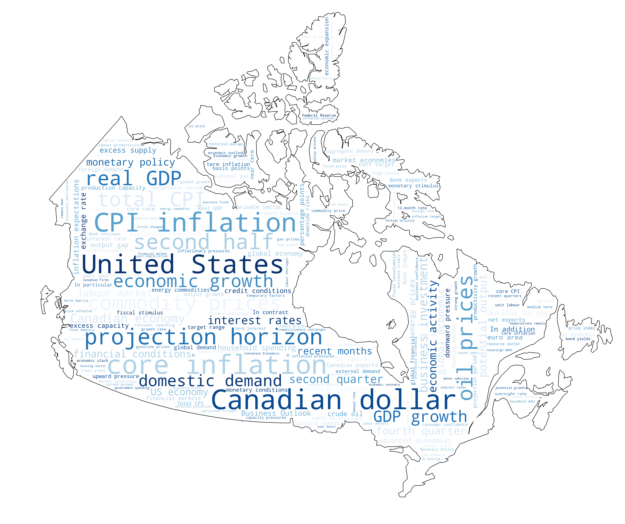

In [17]:
# To create the shape of the Word Cloud - mask3.png is a map of Canada
mask = np.array(Image.open('mask3.png'))

# Creating the cloud
w = wc.WordCloud(mask=mask,mode='RGB',background_color='white',colormap='Blues', contour_width=3, contour_color='black')
#w = wc.WordCloud(mask=mask,width=1920,height=1080,mode='RGBA',background_color=None,contour_width=0.25)

# Plot
plt.figure(figsize=(16,9))
plt.imshow(w.generate_from_frequencies(maket(corpus)),interpolation='bilinear')
plt.axis('off')

plt.savefig('fig2.pdf',bbox_inches='tight')

### Figure 3 - Readability

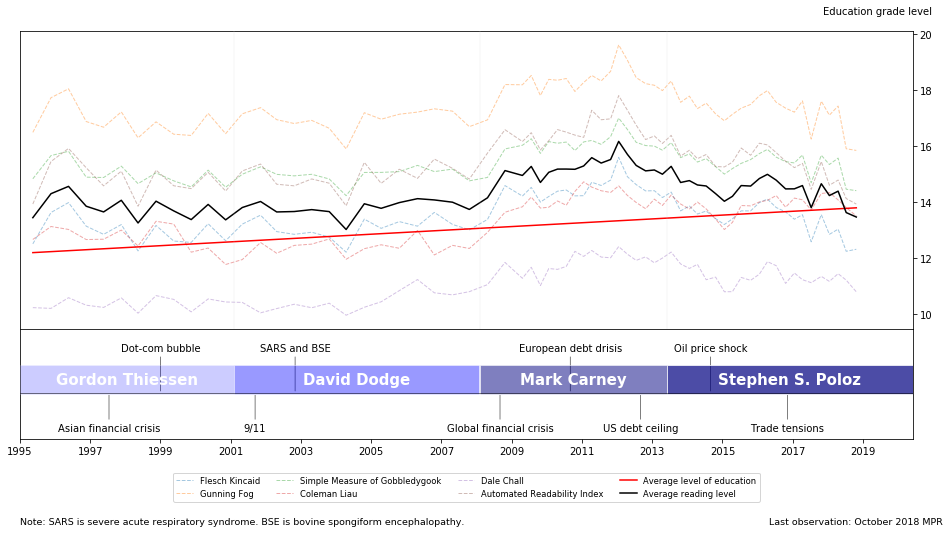

In [11]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]})
plt.subplots_adjust(hspace=0)
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = None

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout

# Calculating readability
readability = pd.DataFrame()
for doc in corpus:
    ts = textacy.TextStats(doc)
    readability.loc[doc.metadata,'Flesch Kincaid'] = ts.readability_stats['flesch_kincaid_grade_level']
    readability.loc[doc.metadata,'Gunning Fog'] = ts.readability_stats['gunning_fog_index']
    readability.loc[doc.metadata,'Simple Measure of Gobbledygook'] = ts.readability_stats['smog_index']
    readability.loc[doc.metadata,'Coleman Liau'] = ts.readability_stats['coleman_liau_index']
    with HiddenPrints():
        c = readcalc.ReadCalc(doc.text)
        readability.loc[doc.metadata,'Dale Chall'] = c.get_dale_chall_score()*2-5.5;
        readability.loc[doc.metadata,'Automated Readability Index'] = c.get_ari_index()
readability.index = pd.to_datetime(readability.index)


# Plot
readability.plot(figsize=(16,9),alpha=.4,ax=ax1,style='--',linewidth=1.0)

#Educational attainment - linear interpolation
ax1.plot([metadata[0],metadata[-1]],[12.2,13.8],color='r',label='Average level of education',linewidth=1.5)
readability.mean(axis=1).plot(label='Average reading level',color='k',legend=True,ax=ax1,linewidth=1.5)
ax2.axhline(0,color='k', zorder=20,linewidth=.5)
ax1.axvline(dt.date(2001,2,1),color='lightgray', zorder=20,linewidth=.2)
ax1.axvline(dt.date(2008,2,1),color='lightgray', zorder=20,linewidth=.2)
ax1.axvline(dt.date(2013,6,3),color='lightgray', zorder=20,linewidth=.2)
rectangles = {'Gordon Thiessen' :patches.Rectangle((thiessenstart,.385*difference+ymin),
                                                   thiessenwidth,(.25*difference), linewidth = 1,
                                                   edgecolor ='w', facecolor='blue', zorder=5, alpha=.2),
              'David Dodge': patches.Rectangle((dodgestart,.385*difference+ymin),dodgewidth,
                                               (.25*difference), linewidth = 1, edgecolor ='w',
                                               facecolor='blue',zorder=5, alpha=.4),
              'Mark Carney': patches.Rectangle((carneystart,.385*difference+ymin),carneywidth
                                               ,(.25*difference), linewidth = 1, edgecolor ='w',
                                               facecolor='navy',zorder=5, alpha=.5),
              'Stephen S. Poloz': patches.Rectangle((polozstart,.385*difference+ymin),polozwidth,
                                                   (.25*difference), linewidth = 1,edgecolor ='w',
                                                   facecolor='navy',zorder=5, alpha=.7)}
for r in rectangles:
    ax2.add_artist(rectangles[r])
    rx, ry = rectangles[r].get_xy()
    cx = rx + rectangles[r].get_width()/2.0
    cy = ry + rectangles[r].get_height()/2.0
    ax2.annotate(r, (cx, cy), color='white', weight='bold', 
                fontsize=15, ha='center', va='center', zorder=20)
ax2.set_xlim((dt.date(1995,1,1),dt.date(2020,6,2)))
years = pd.to_datetime(range(1995,2020,2), format='%Y')
yearnumbers = mdates.date2num(years.to_pydatetime())
ax2.set_xticks(yearnumbers)
ax2.set_yticks([])
starttime = (dt.date(1995,1,1))
endtime = (dt.date(2022,1,31))
start = mdates.date2num(starttime)
end = mdates.date2num(endtime)
plt.plot(dates,values, color='w')
annotations = sorted([
    (dt.date(1997,7,15),'Asian financial crisis',-3.5),
    (dt.date(1999,1,1),'Dot-com bubble',4.5),
    (dt.date(2001,9,11),'9/11',-3.5),
    (dt.date(2002,11,1),'SARS and BSE',4.5),
    (dt.date(2008,9,1),'Global financial crisis',-3.5),
    (dt.date(2010,9,1),'European debt drisis',4.5),
    (dt.date(2012,9,1),'US debt ceiling',-3.5),
    (dt.date(2014,9,1),'Oil price shock',4.5),
    (dt.date(2016,11,8),'Trade tensions',-3.5)
])
for q, a in enumerate(annotations):
    w = a[2]
    dm = mdates.date2num(a[0])
    plt.annotate(a[1],xy=(dm,0),xytext=(dm,.5*0 + w),
            arrowprops=dict(facecolor='black', arrowstyle='-',linewidth=.5),
            ha='center',va='center')
ax2.minorticks_off()
box1 = ax1.get_position()
box2 = ax2.get_position()
ax1.set_position([box1.x0, box1.y0 + box1.height * 0.1,
                 box1.width, box1.height * 0.9])
ax2.set_position([box2.x0, box2.y0+box1.height*0.1,
                 box2.width, box2.height])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3-box2.height),
          fancybox=True, shadow=False, ncol=4, fontsize = 'small')
ax1.yaxis.tick_right()
ax1.set_ylabel("Education grade level", rotation='horizontal')
ax1.yaxis.set_label_coords(0.96,1.05)

plt.text(0.125, 0.12, 'Note: SARS is severe acute respiratory syndrome. BSE is bovine spongiform encephalopathy.', transform=plt.gcf().transFigure, fontsize=9.5)
plt.text(.775, 0.12, 'Last observation: October 2018 MPR', transform=plt.gcf().transFigure, fontsize=9.5)

plt.savefig('fig3.pdf',bbox_inches='tight')

### Figure 4 - Length

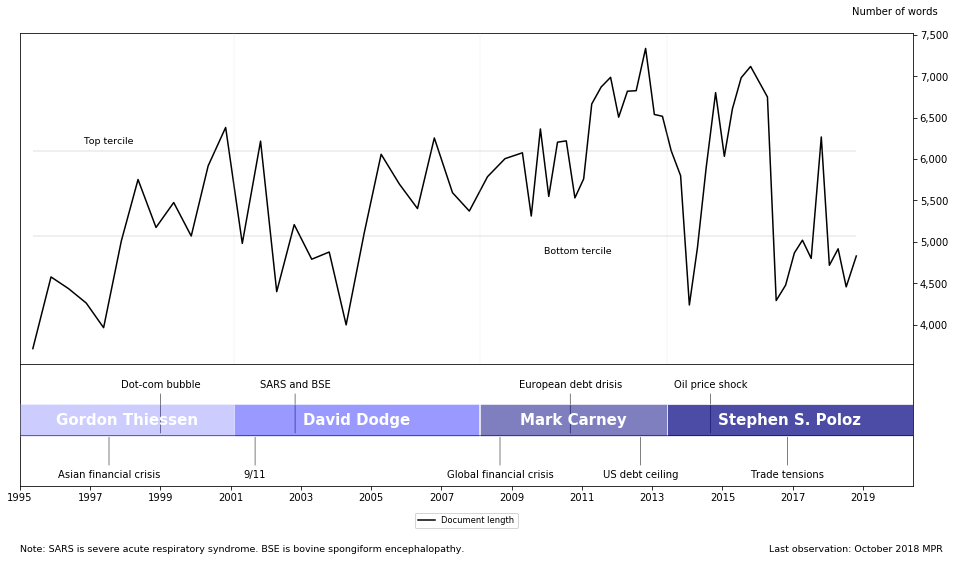

In [12]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]})
plt.subplots_adjust(hspace=0)


# Calculating the number of word in the MPRs
length = pd.DataFrame(index=metadata, columns=['Document length'],data=list(map(len,corpus.docs)))
bottom_tercile = pd.DataFrame(index=metadata, columns=['Bottom tercile'],data=np.percentile(length,(100/3)*1,interpolation="nearest"))
top_tercile = pd.DataFrame(index=metadata, columns=['Top tercile'],data=np.percentile(length,(100/3)*2,interpolation="nearest"))



# Plot
length.plot(figsize=(16,9),alpha=1,ax=ax1,color='k',linewidth=1.5)
bottom_tercile.plot(figsize=(16,9),alpha=1,ax=ax1,color='gray',linewidth=0.25)
top_tercile.plot(figsize=(16,9),alpha=1,ax=ax1,color='gray',linewidth=0.25)


ax2.axhline(0,color='k', zorder=20,linewidth=.5)
ax1.axvline(dt.date(2001,2,1),color='lightgray', zorder=20,linewidth=.2)
ax1.axvline(dt.date(2008,2,1),color='lightgray', zorder=20,linewidth=.2)
ax1.axvline(dt.date(2013,6,3),color='lightgray', zorder=20,linewidth=.2)
rectangles = {'Gordon Thiessen' :patches.Rectangle((thiessenstart,.385*difference+ymin),
                                                   thiessenwidth,(.25*difference), linewidth = 1,
                                                   edgecolor ='w', facecolor='blue', zorder=5, alpha=.2),
              'David Dodge': patches.Rectangle((dodgestart,.385*difference+ymin),dodgewidth,
                                               (.25*difference), linewidth = 1, edgecolor ='w',
                                               facecolor='blue',zorder=5, alpha=.4),
              'Mark Carney': patches.Rectangle((carneystart,.385*difference+ymin),carneywidth
                                               ,(.25*difference), linewidth = 1, edgecolor ='w',
                                               facecolor='navy',zorder=5, alpha=.5),
              'Stephen S. Poloz': patches.Rectangle((polozstart,.385*difference+ymin),polozwidth,
                                                   (.25*difference), linewidth = 1,edgecolor ='w',
                                                   facecolor='navy',zorder=5, alpha=.7)}
for r in rectangles:
    ax2.add_artist(rectangles[r])
    rx, ry = rectangles[r].get_xy()
    cx = rx + rectangles[r].get_width()/2.0
    cy = ry + rectangles[r].get_height()/2.0
    ax2.annotate(r, (cx, cy), color='white', weight='bold', 
                fontsize=15, ha='center', va='center', zorder=20)
ax2.set_xlim((dt.date(1995,1,1),dt.date(2020,6,2)))
years = pd.to_datetime(range(1995,2020,2), format='%Y')
yearnumbers = mdates.date2num(years.to_pydatetime())
ax2.set_xticks(yearnumbers)
ax2.set_yticks([])
starttime = (dt.date(1995,1,1))
endtime = (dt.date(2022,1,31))
start = mdates.date2num(starttime)
end = mdates.date2num(endtime)
plt.plot(dates,values, color='w')
annotations = sorted([
    (dt.date(1997,7,15),'Asian financial crisis',-3.5),
    (dt.date(1999,1,1),'Dot-com bubble',4.5),
    (dt.date(2001,9,11),'9/11',-3.5),
    (dt.date(2002,11,1),'SARS and BSE',4.5),
    (dt.date(2008,9,1),'Global financial crisis',-3.5),
    (dt.date(2010,9,1),'European debt drisis',4.5),
    (dt.date(2012,9,1),'US debt ceiling',-3.5),
    (dt.date(2014,9,1),'Oil price shock',4.5),
    (dt.date(2016,11,8),'Trade tensions',-3.5)
])
for q, a in enumerate(annotations):
    w = a[2]
    dm = mdates.date2num(a[0])
    plt.annotate(a[1],xy=(dm,0),xytext=(dm,.5*0 + w),\
            arrowprops=dict(facecolor='black', arrowstyle='-',linewidth=.5),\
            ha='center',va='center')
ax2.minorticks_off()
box1 = ax1.get_position()
box2 = ax2.get_position()
ax1.set_position([box1.x0, box1.y0 + box1.height * 0.1,
                 box1.width, box1.height * 0.9])
ax2.set_position([box2.x0, box2.y0+box1.height*0.1,
                 box2.width, box2.height])
ax1.legend((length),loc='upper center', bbox_to_anchor=(0.5, -0.25-box2.height),\
          fancybox=True, shadow=False, ncol=4, fontsize = 'small')

ax1.yaxis.tick_right()
ax1.set_ylabel("Number of words", rotation='horizontal')
ax1.yaxis.set_label_coords(0.98,1.05)
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.text(0.125, 0.08, 'Note: SARS is severe acute respiratory syndrome. BSE is bovine spongiform encephalopathy.', transform=plt.gcf().transFigure, fontsize=9.5)
plt.text(.775, 0.08, 'Last observation: October 2018 MPR', transform=plt.gcf().transFigure, fontsize=9.5)

plt.text(.18, 0.71, 'Top tercile', transform=plt.gcf().transFigure, fontsize=9.5)
plt.text(.58, 0.54, 'Bottom tercile', transform=plt.gcf().transFigure, fontsize=9.5)


plt.savefig('fig4.pdf',bbox_inches='tight')

### Figure 5 - Lexical innovations

In [13]:
# Calculating distance between MPRs

def word_movers2(doc1, doc2, metric='cosine'):
    '''
    This is the exact same as 
    https://github.com/chartbeat-labs/textacy/blob/e228aab09a3e59655e2f86266565ee84d20914a5/textacy/similarity.py#L31
    
    but with libwmdrelax from 
    https://github.com/src-d/wmd-relax
    '''
    word_idxs = dict()
    n = 0
    word_vecs = []
    for word in itertoolz.concatv(extract.words(doc1), extract.words(doc2)):
        if word.has_vector and word_idxs.setdefault(word.orth, n) == n:
            word_vecs.append(word.vector)
            n += 1
    distance_mat = pairwise_distances(np.array(word_vecs), metric=metric).astype(np.float32)
    distance_mat /= distance_mat.max()
    vec1 = collections.Counter(
        word_idxs[word.orth]
        for word in extract.words(doc1)
        if word.has_vector)
    vec1 = np.array([vec1[word_idx] for word_idx in compat.range_(len(word_idxs))]).astype(np.float32)
    vec1 /= vec1.sum()  # normalize word counts
    vec2 = collections.Counter(
        word_idxs[word.orth]
        for word in extract.words(doc2)
        if word.has_vector)
    vec2 = np.array([vec2[word_idx] for word_idx in compat.range_(len(word_idxs))]).astype(np.float32)
    vec2 /= vec2.sum()  # normalize word counts
    return 1.0 - libwmdrelax.emd(vec1, vec2, distance_mat)


def get_wm(ind,lag_num,*args,**kwargs):
    return 1-word_movers2(nlp_vec("\n".join(data[ind-lag_num:ind])),nlp_vec(data[ind]))

In [14]:
%%time

# Run this cell to compute the entire history

from multiprocessing.pool import Pool
os.environ["OMP_NUM_THREADS"] = str(1)
with Pool(os.cpu_count()//2) as pool:
    wm_df = pd.DataFrame(index=metadata[1:])
    for lag_num in [1,4,8,16]:
        wm_df = pd.concat((wm_df,pd.DataFrame(index = metadata[lag_num:], columns=['U{}'.format(lag_num)],
              data = list(pool.starmap(get_wm,list(zip(range(lag_num,len(corpus)),
                                                  (lag_num for _ in range(lag_num,len(corpus))))))))),axis=1, sort=True)

# add top row of None to be consistent with the other cell (one document)

wm_df = pd.concat([
    pd.DataFrame(None, index=[metadata[0]], columns=wm_df.columns), 
    wm_df
], axis=0)

CPU times: user 448 ms, sys: 624 ms, total: 1.07 s
Wall time: 2min 24s


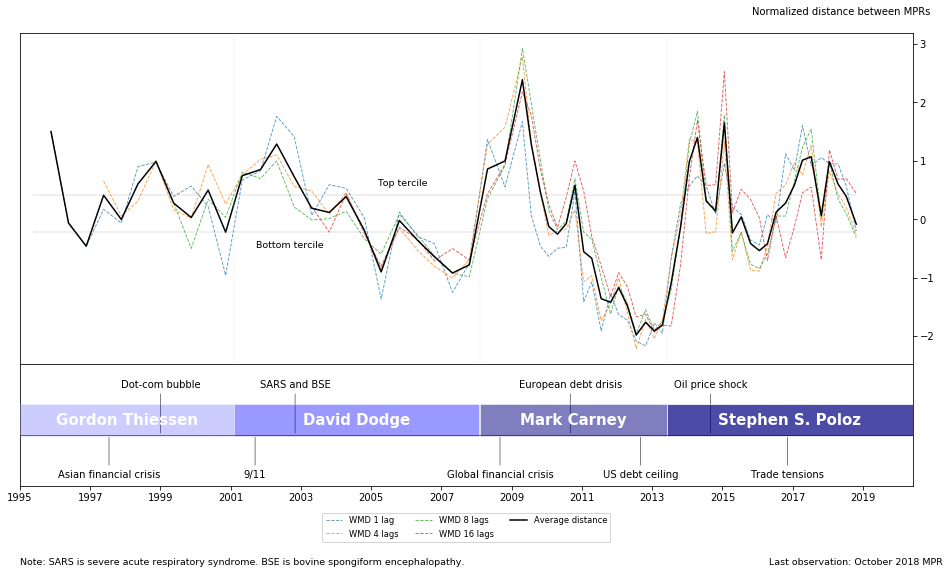

In [15]:
# Figure 5

Ulags = [1,4,8,16]

wm_df_nrm = wm_df.dropna(axis=0, how='all')
wm_df_nrm.columns = ['WMD {lag_num} lag{s}'.format(lag_num=lag_num, s="s" if lag_num > 1 else "")
                for lag_num in Ulags]
wm_df_nrm = ((wm_df_nrm-wm_df_nrm.mean())/wm_df_nrm.std())

fig, ((ax1, ax2)) = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]})
plt.subplots_adjust(hspace=0)


# Plot
wm_df_nrm.plot(figsize=(16,9),alpha=0.75,ax=ax1,linewidth=0.9, style='--')
wm_df_nrm.mean(axis=1).plot(figsize=(16,9),alpha=1,ax=ax1, color='k', linewidth=1.5, label='Average distance')

bottom_tercile = pd.DataFrame(index=metadata, columns=[''],data=np.percentile(wm_df_nrm.mean(axis=1),(100/3)*1,interpolation="nearest"))
top_tercile = pd.DataFrame(index=metadata, columns=[''],data=np.percentile(wm_df_nrm.mean(axis=1),(100/3)*2,interpolation="nearest"))


bottom_tercile.plot(figsize=(16,9),alpha=1,ax=ax1,color='gray',linewidth=0.25)
top_tercile.plot(figsize=(16,9),alpha=1,ax=ax1,color='gray',linewidth=0.25)

ax2.axhline(0,color='k', zorder=20,linewidth=.5)
ax1.axvline(dt.date(2001,2,1),color='lightgray', zorder=20,linewidth=.2)
ax1.axvline(dt.date(2008,2,1),color='lightgray', zorder=20,linewidth=.2)
ax1.axvline(dt.date(2013,6,3),color='lightgray', zorder=20,linewidth=.2)
rectangles = {'Gordon Thiessen' :patches.Rectangle((thiessenstart,.385*difference+ymin),
                                                   thiessenwidth,(.25*difference), linewidth = 1,
                                                   edgecolor ='w', facecolor='blue', zorder=5, alpha=.2),
              'David Dodge': patches.Rectangle((dodgestart,.385*difference+ymin),dodgewidth,
                                               (.25*difference), linewidth = 1, edgecolor ='w',
                                               facecolor='blue',zorder=5, alpha=.4),
              'Mark Carney': patches.Rectangle((carneystart,.385*difference+ymin),carneywidth
                                               ,(.25*difference), linewidth = 1, edgecolor ='w',
                                               facecolor='navy',zorder=5, alpha=.5),
              'Stephen S. Poloz': patches.Rectangle((polozstart,.385*difference+ymin),polozwidth,
                                                   (.25*difference), linewidth = 1,edgecolor ='w',
                                                   facecolor='navy',zorder=5, alpha=.7)}
for r in rectangles:
    ax2.add_artist(rectangles[r])
    rx, ry = rectangles[r].get_xy()
    cx = rx + rectangles[r].get_width()/2.0
    cy = ry + rectangles[r].get_height()/2.0
    ax2.annotate(r, (cx, cy), color='white', weight='bold', 
                fontsize=15, ha='center', va='center', zorder=20)
ax2.set_xlim((dt.date(1995,1,1),dt.date(2020,6,2)))
years = pd.to_datetime(range(1995,2020,2), format='%Y')
yearnumbers = mdates.date2num(years.to_pydatetime())
ax2.set_xticks(yearnumbers)
ax2.set_yticks([])
starttime = (dt.date(1995,1,1))
endtime = (dt.date(2022,1,31))
start = mdates.date2num(starttime)
end = mdates.date2num(endtime)
plt.plot(dates,values, color='w')
annotations = sorted([
    (dt.date(1997,7,15),'Asian financial crisis',-3.5),
    (dt.date(1999,1,1),'Dot-com bubble',4.5),
    (dt.date(2001,9,11),'9/11',-3.5),
    (dt.date(2002,11,1),'SARS and BSE',4.5),
    (dt.date(2008,9,1),'Global financial crisis',-3.5),
    (dt.date(2010,9,1),'European debt drisis',4.5),
    (dt.date(2012,9,1),'US debt ceiling',-3.5),
    (dt.date(2014,9,1),'Oil price shock',4.5),
    (dt.date(2016,11,8),'Trade tensions',-3.5)
])
for q, a in enumerate(annotations):
    w = a[2]
    dm = mdates.date2num(a[0])
    plt.annotate(a[1],xy=(dm,0),xytext=(dm,.5*0 + w),\
            arrowprops=dict(facecolor='black', arrowstyle='-',linewidth=.5),\
            ha='center',va='center')
ax2.minorticks_off()
box1 = ax1.get_position()
box2 = ax2.get_position()
ax1.set_position([box1.x0, box1.y0 + box1.height * 0.1,
                 box1.width, box1.height * 0.9])
ax2.set_position([box2.x0, box2.y0+box1.height*0.1,
                 box2.width, box2.height])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25-box2.height),\
          fancybox=True, shadow=False, ncol=3, fontsize = 'small')

ax1.yaxis.tick_right()
ax1.set_ylabel("Normalized distance between MPRs", rotation='horizontal')
ax1.yaxis.set_label_coords(0.92,1.05)

plt.text(0.125, 0.06, 'Note: SARS is severe acute respiratory syndrome. BSE is bovine spongiform encephalopathy.', transform=plt.gcf().transFigure, fontsize=9.5)
plt.text(.775, 0.06, 'Last observation: October 2018 MPR', transform=plt.gcf().transFigure, fontsize=9.5)

plt.text(.435, 0.645, 'Top tercile', transform=plt.gcf().transFigure, fontsize=9.5)
plt.text(.33, 0.55, 'Bottom tercile', transform=plt.gcf().transFigure, fontsize=9.5)

plt.savefig('fig5.pdf',bbox_inches='tight')